# Plotting validation periods

---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
%load_ext autoreload
%autoreload 2
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (MeasureList, Interval,
                          BetaMultiplierMeasureByType,
                          SocialDistancingForAllMeasure, 
                          SocialDistancingForPositiveMeasure,
                          SocialDistancingForPositiveMeasureHousehold)
from lib.inference import gen_initial_seeds, extract_seeds_from_summary
from lib.plot import Plotter
from lib.settings.calibration_settings import (
    settings_optimized_town_params, 
    command_line_area_codes, 
    settings_lockdown_dates)
import matplotlib.pyplot as plt
%matplotlib inline

# converting days to hours
TO_HOURS = 24.0

In [3]:
c = 0
np.random.seed(c)
random_repeats = 16 # Set to at least 40 to obtain stable results
num_workers = multiprocessing.cpu_count()

In [4]:
def standard_testing(max_time, new_cases__):
    daily_increase = new_cases__.sum(axis=1)[1:] - new_cases__.sum(axis=1)[:-1]
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 1 * TO_HOURS,     # in hours
        'test_reporting_lag'  : 2 * TO_HOURS,     # in hours (actual and self-report delay)
        'tests_per_batch'     : int(daily_increase.max()), # test capacity based on empirical positive tests
        'test_fpr'            : 0.0, # test false positive rate
        'test_fnr'            : 0.0, # test false negative rate
        'test_smart_delta'    : 3 * TO_HOURS, # in hours
        'test_smart_duration' : 7 * TO_HOURS, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

#### Simulate for each town

In [8]:
mob_setting_paths = {
    'GER' : {
        'TU' : ['lib/mobility/Tubingen_settings_10_10_hh.pk', 10, '2020-03-10', '2020-03-26'],
        'KL' : ['lib/mobility/Kaiserslautern_settings_10_10_hh.pk', 10, '2020-03-18', '2020-03-26'],
        'RH' : ['lib/mobility/Ruedesheim_settings_10_10_hh.pk', 10, '2020-03-10', '2020-03-26'],
        'TR' : ['lib/mobility/Tirschenreuth_settings_10_10_hh.pk', 10, '2020-03-10', '2020-03-26'],
    },
    'CH' : {
        'VD' : ['lib/mobility/Lausanne_settings_10_10_hh.pk', 10, '2020-03-06', '2020-03-18'],
        'LU' : ['lib/mobility/Lucerne_settings_5_5_hh.pk', 5, '2020-03-04', '2020-03-18'],
        'TI' : ['lib/mobility/Locarno_settings_5_5_hh.pk', 5, '2020-03-03', '2020-03-18'],
        'SZ' : ['lib/mobility/Schwyz_settings_10_10_hh.pk', 10, '2020-03-09', '2020-03-18'],
    }
}

    
for country in ['GER', 'CH']:
    for area in mob_setting_paths[country].keys():

        mob_settings = mob_setting_paths[country][area][0]
        case_downsample = mob_setting_paths[country][area][1]                           
        start_date = mob_setting_paths[country][area][2]
        end_date = mob_setting_paths[country][area][3]

        sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        max_time = TO_HOURS * sim_days # in hours

        # load mobility file
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)

        # case data
        new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
        start_date_string=start_date, end_date_string=end_date)
        new_cases = np.ceil(1/case_downsample * new_cases_)

        # distributions
        distributions = CovidDistributions(country=country)

        # seeds
        initial_seeds = gen_initial_seeds(new_cases)

        # calibrated parameters
        inferred_params = settings_optimized_town_params[country][area]

        # run
        measure_list =  [
            SocialDistancingForPositiveMeasure(
                t_window=Interval(0.0, max_time), p_stay_home=1.0),

            SocialDistancingForPositiveMeasureHousehold(
                t_window=Interval(0.0, max_time), p_isolate=1.0)
        ]
        measure_list = MeasureList(measure_list)

        # testing
        tparam = standard_testing(max_time, new_cases)

        # run simulations
        summary = launch_parallel_simulations(
            mob_settings, 
            distributions, 
            random_repeats, num_workers, 
            inferred_params, initial_seeds, tparam, measure_list, 
            max_time=max_time, 
            num_people=mob.num_people, 
            num_sites=mob.num_sites, 
            site_loc=mob.site_loc, 
            home_loc=mob.home_loc,
            dynamic_tracing=True,
            verbose=False)

        save_summary(summary, 'summary_calib_{}_{}.pk'.format(country, area))


GER TU
GER KL
GER RH
GER TR
CH VD
CH LU
CH TI
CH SZ


---

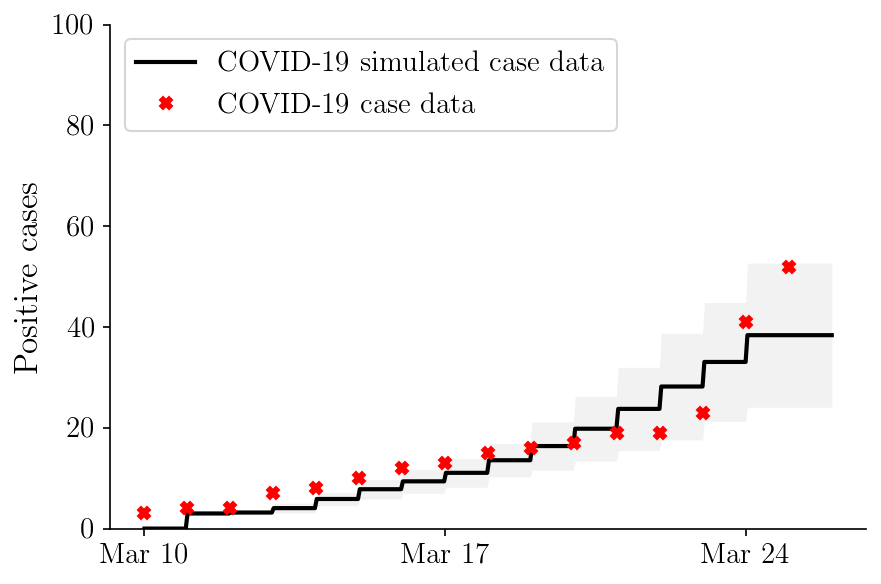

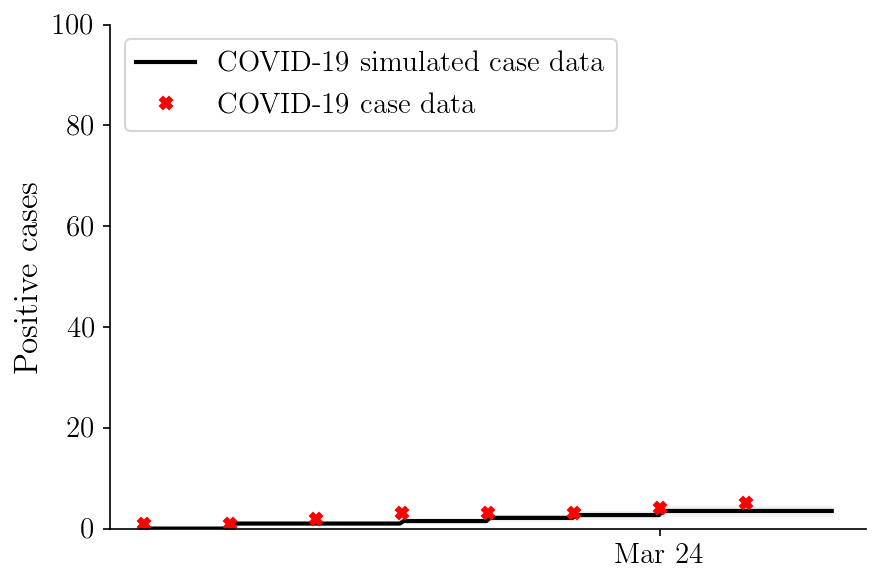

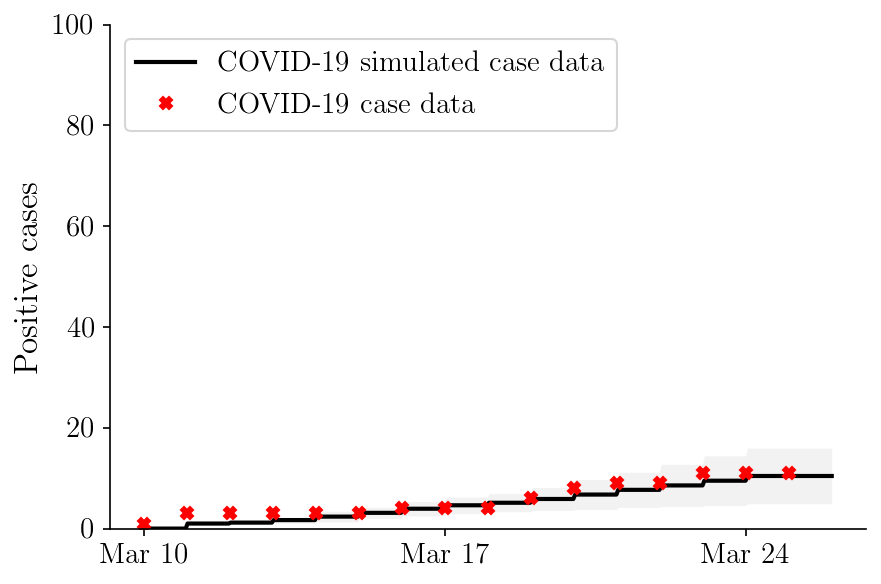

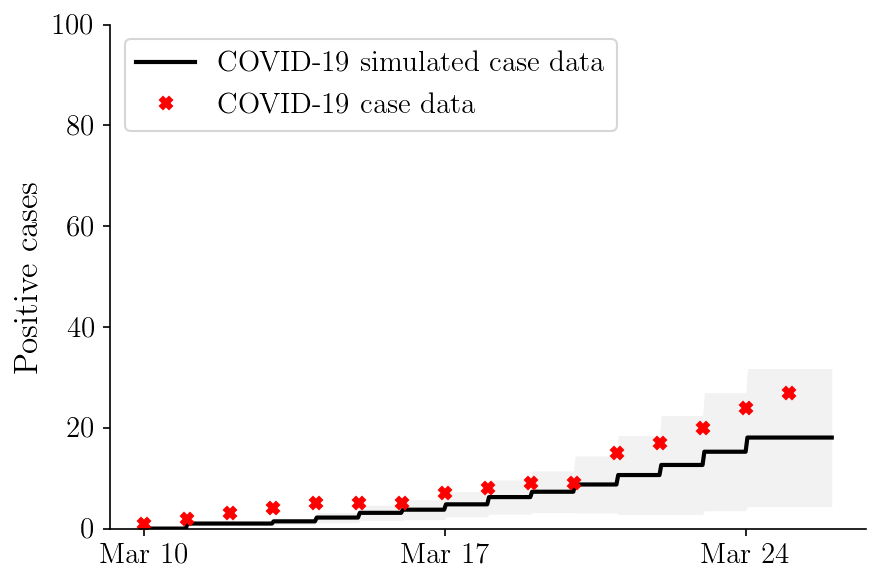

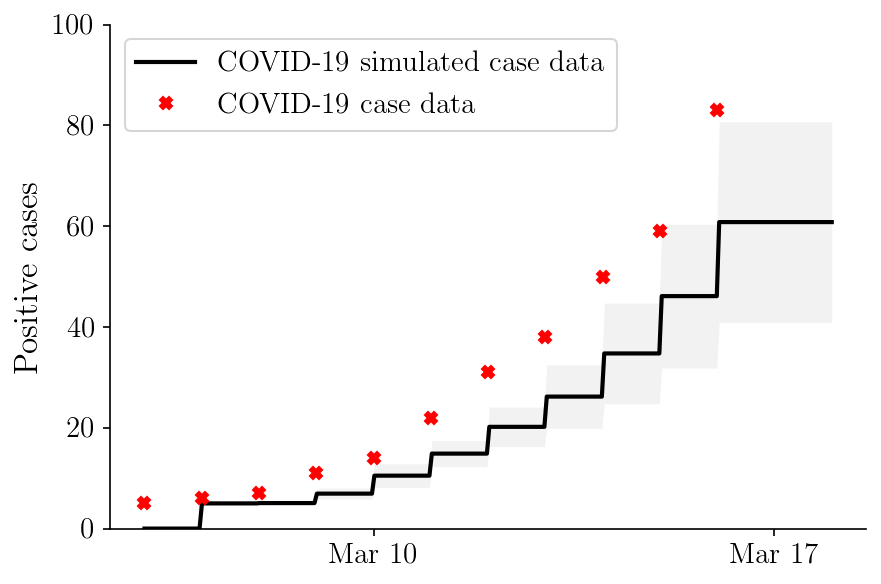

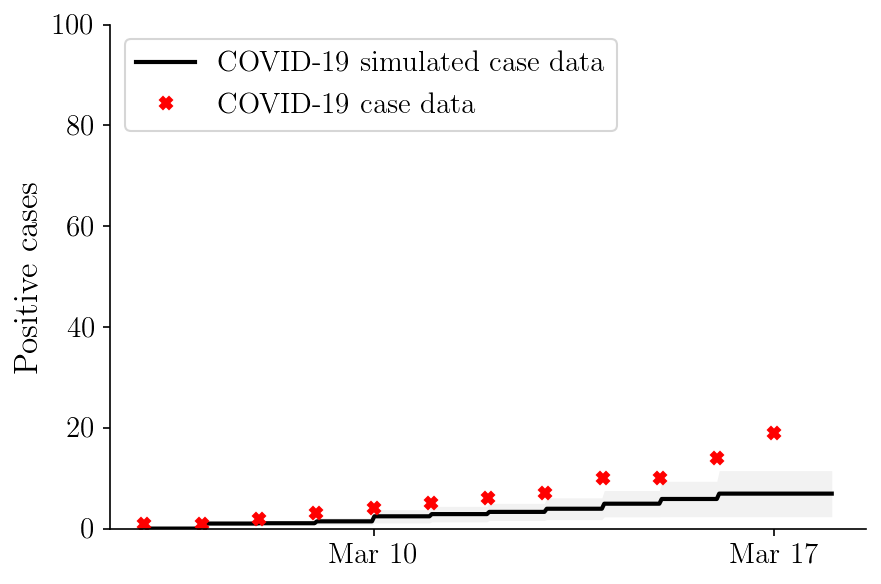

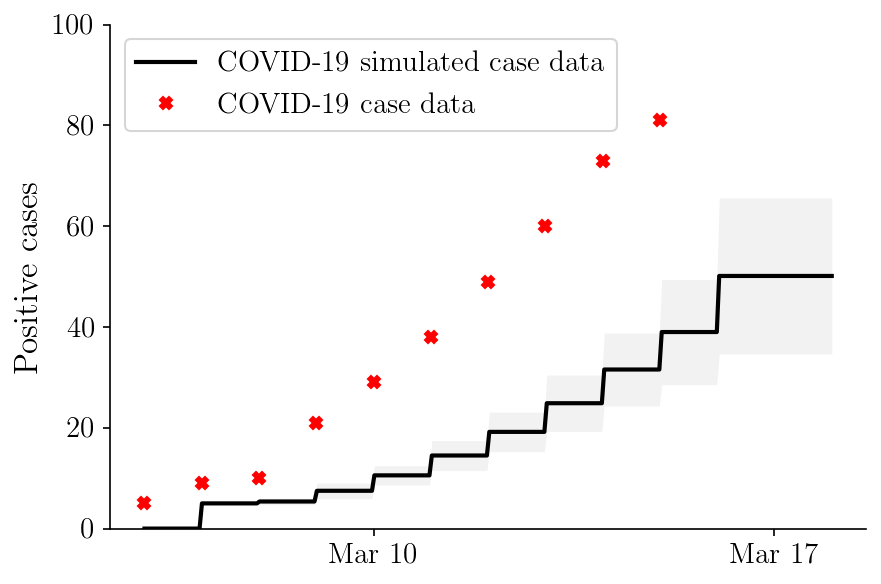

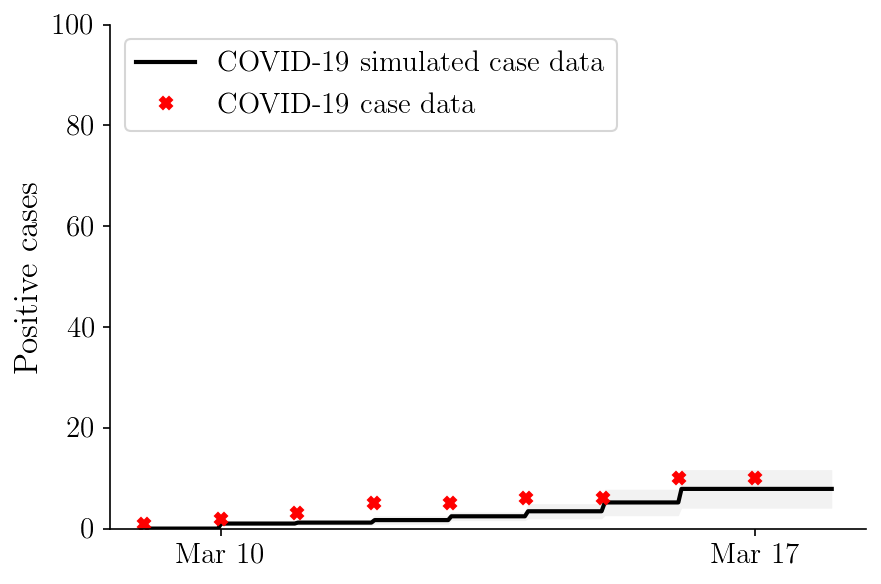

In [10]:
    
for country in ['GER', 'CH']:
    for area in mob_setting_paths[country].keys():
        
        mob_settings = mob_setting_paths[country][area][0]
        case_downsample = mob_setting_paths[country][area][1]                           
        start_date = mob_setting_paths[country][area][2]
        end_date = mob_setting_paths[country][area][3]
    
        sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        max_time = TO_HOURS * sim_days # in hours
        
        # load mobility file
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)

        # case data
        new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
        start_date_string=start_date, end_date_string=end_date)
        new_cases = np.ceil(1/case_downsample * new_cases_)
        
        summary = load_summary('summary_calib_{}_{}.pk'.format(country, area))
        plotter = Plotter()
        plotter.plot_positives_vs_target(
            summary, new_cases.sum(axis=1), 
            test_lag=2,
            title='Calibration period', 
            filename='calibration_{}_{}_00'.format(country, area),
            figsize=(6, 4),
            start_date=start_date,
            errorevery=1, acc=1000, 
#             lockdown_at=lockdown_at_day,
            ymax=100)
